In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


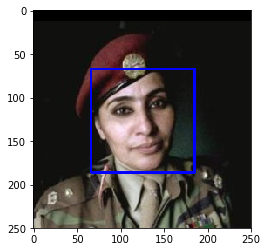

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

# Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
fc_human = [face_detector(h) for h in human_files_short]
fc_dog = [face_detector(d) for d in dog_files_short]

In [6]:
# Percentage of human faces detected in human and dog images.
fc_human_pc = sum([h>0 for h in fc_human])/len(fc_human) * 100
fc_dog_pc = sum([d>0 for d in fc_dog])/len(fc_dog) * 100

print("{}% of the first 100 human images detected a human face.".format(fc_human_pc))
print("{}% of the first 100 dog images detected a human face.".format(fc_dog_pc))

100.0% of the first 100 human images detected a human face.
11.0% of the first 100 dog images detected a human face.


In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [12]:
#Test the performance of the dog_detector function
##on the images in human_files_short and dog_files_short.
dd_human = [dog_detector(h) for h in human_files_short]
dd_dog = [dog_detector(d) for d in dog_files_short]

In [13]:
dd_human_pc = sum([h>0 for h in dd_human])/len(dd_human) * 100
dd_dog_pc = sum([d>0 for d in dd_dog])/len(dd_dog) * 100

print("{}% of the first 100 human images detected a dog.".format(dd_human_pc))
print("{}% of the first 100 dog images detected a dog.".format(dd_dog_pc))

0.0% of the first 100 human images detected a dog.
100.0% of the first 100 dog images detected a dog.


In [14]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 95.00it/s] 


In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# Define your architecture.

model.add(Conv2D(input_shape = (224, 224, 3), filters = 8, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size= 2, data_format='channels_last'))
model.add(Conv2D(filters = 16, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size= 2, data_format='channels_last'))
model.add(Conv2D(filters = 32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size= 2, data_format='channels_last'))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='relu'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 8)       104       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 16)      528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint

## specify the number of epochs that you would like to use to train the model.
epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 15s 2ms/step - loss: 12.2583 - acc: 0.0061 - val_loss: 12.3579 - val_acc: 0.0072
Epoch 2/5
6680/6680 [==============================] - 15s 2ms/step - loss: 12.8382 - acc: 0.0094 - val_loss: 13.2266 - val_acc: 0.0060
Epoch 3/5
6680/6680 [==============================] - 15s 2ms/step - loss: 13.7944 - acc: 0.0103 - val_loss: 13.3234 - val_acc: 0.0072
Epoch 4/5
6680/6680 [==============================] - 15s 2ms/step - loss: 13.5213 - acc: 0.0091 - val_loss: 14.0954 - val_acc: 0.0108
Epoch 5/5
6680/6680 [==============================] - 15s 2ms/step - loss: 12.8189 - acc: 0.0102 - val_loss: 12.3984 - val_acc: 0.0096


### Load the Model with the Best Validation Loss

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.0766%


In [20]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [21]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [22]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 302us/step - loss: 12.3211 - acc: 0.1093 - val_loss: 10.6025 - val_acc: 0.2144
Epoch 2/20
6680/6680 [==============================] - 2s 256us/step - loss: 9.8388 - acc: 0.2867 - val_loss: 9.8971 - val_acc: 0.2838
Epoch 3/20
6680/6680 [==============================] - 2s 258us/step - loss: 9.2844 - acc: 0.3599 - val_loss: 9.4550 - val_acc: 0.3317
Epoch 4/20
6680/6680 [==============================] - 2s 255us/step - loss: 8.9406 - acc: 0.3985 - val_loss: 9.3441 - val_acc: 0.3329
Epoch 5/20
6680/6680 [==============================] - 2s 253us/step - loss: 8.6961 - acc: 0.4207 - val_loss: 9.1719 - val_acc: 0.3521
Epoch 6/20
6680/6680 [==============================] - 2s 256us/step - loss: 8.5978 - acc: 0.4394 - val_loss: 9.0776 - val_acc: 0.3689
Epoch 7/20
6680/6680 [==============================] - 2s 258us/step - loss: 8.5018 - acc: 0.4493 - val_loss: 8.9994 - val_acc: 0.3760

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.1388%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [27]:
#Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

In [28]:
### TODO: Define your architecture.
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
inception_model.add(Dense(133, activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Compile the model.
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [30]:
# Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 360us/step - loss: 1.1539 - acc: 0.7037 - val_loss: 0.6282 - val_acc: 0.8132
Epoch 2/20
6680/6680 [==============================] - 2s 309us/step - loss: 0.4717 - acc: 0.8555 - val_loss: 0.7000 - val_acc: 0.8335
Epoch 3/20
6680/6680 [==============================] - 2s 309us/step - loss: 0.3703 - acc: 0.8891 - val_loss: 0.6811 - val_acc: 0.8383
Epoch 4/20
6680/6680 [==============================] - 2s 309us/step - loss: 0.2999 - acc: 0.9066 - val_loss: 0.6698 - val_acc: 0.8551
Epoch 5/20
6680/6680 [==============================] - 2s 311us/step - loss: 0.2372 - acc: 0.9254 - val_loss: 0.6805 - val_acc: 0.8467
Epoch 6/20
6680/6680 [==============================] - 2s 309us/step - loss: 0.2041 - acc: 0.9365 - val_loss: 0.7015 - val_acc: 0.8431
Epoch 7/20
6680/6680 [==============================] - 2s 311us/step - loss: 0.1748 - acc: 0.9457 - val_loss: 0.7218 - val_acc: 0.8443
E

In [31]:
#Load the model weights with the best validation loss.
inception_model.load_weights('saved_models/weights.best.inception.hdf5')

In [32]:
# Calculate classification accuracy on the test dataset.
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.9904%


In [33]:
#function which takes a path to an image as input
#and returns the dog breed that is predicted by the model.

def predict_breed(img_path):
    
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    
    # obtain predicted vector
    pred_vector = inception_model.predict(bottleneck_feature)
    
    # return predicted dog breed
    return dog_names[np.argmax(pred_vector)]

In [34]:
#Write your algorithm.
from IPython.core.display import Image, display

def breed_algorithm(img_path):
    display(Image(img_path, width=200, height=200))
    
    if dog_detector(img_path) == 1:
        print("This is predicted to be a dog, and its breed is: ")
        return predict_breed(img_path).partition('.')[-1]
    
    elif face_detector(img_path) == 1:
        print("This is predicted to be a human, and its spirit animal is a: ")
        return predict_breed(img_path).partition('.')[-1]
    
    else:
        return print("It wasn't possible to identify a human or dog in the image. Please try again.")

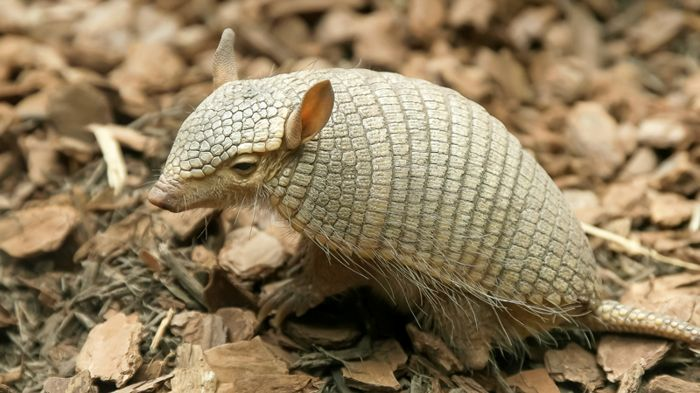

It wasn't possible to identify a human or dog in the image. Please try again.
None


In [35]:
# Execute algorithm


print(breed_algorithm("test1.jpg"))

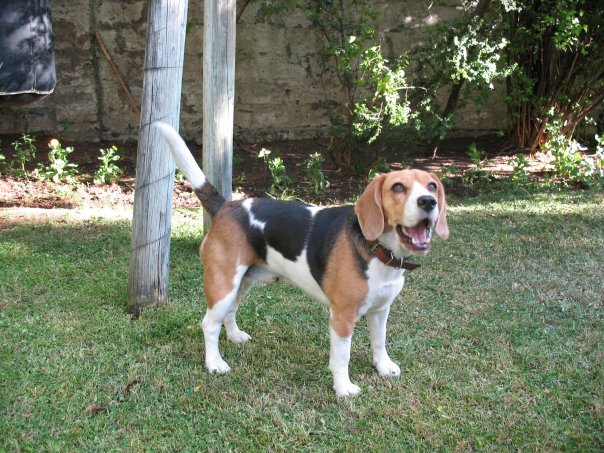

This is predicted to be a dog, and its breed is: 
American_foxhound


In [41]:
print(breed_algorithm("test2.jpg"))

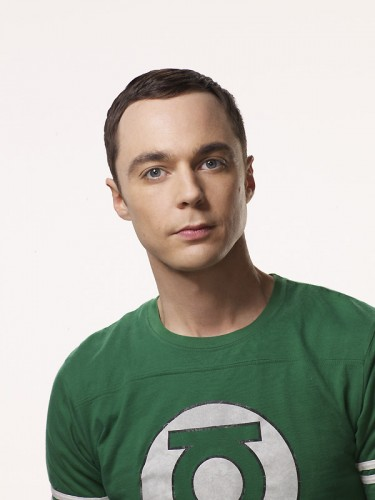

This is predicted to be a human, and its spirit animal is a: 
Black_and_tan_coonhound


In [37]:
print(breed_algorithm("test3.jpg"))

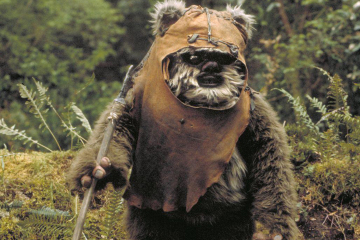

It wasn't possible to identify a human or dog in the image. Please try again.
None


In [38]:
print(breed_algorithm("test4.jpeg"))

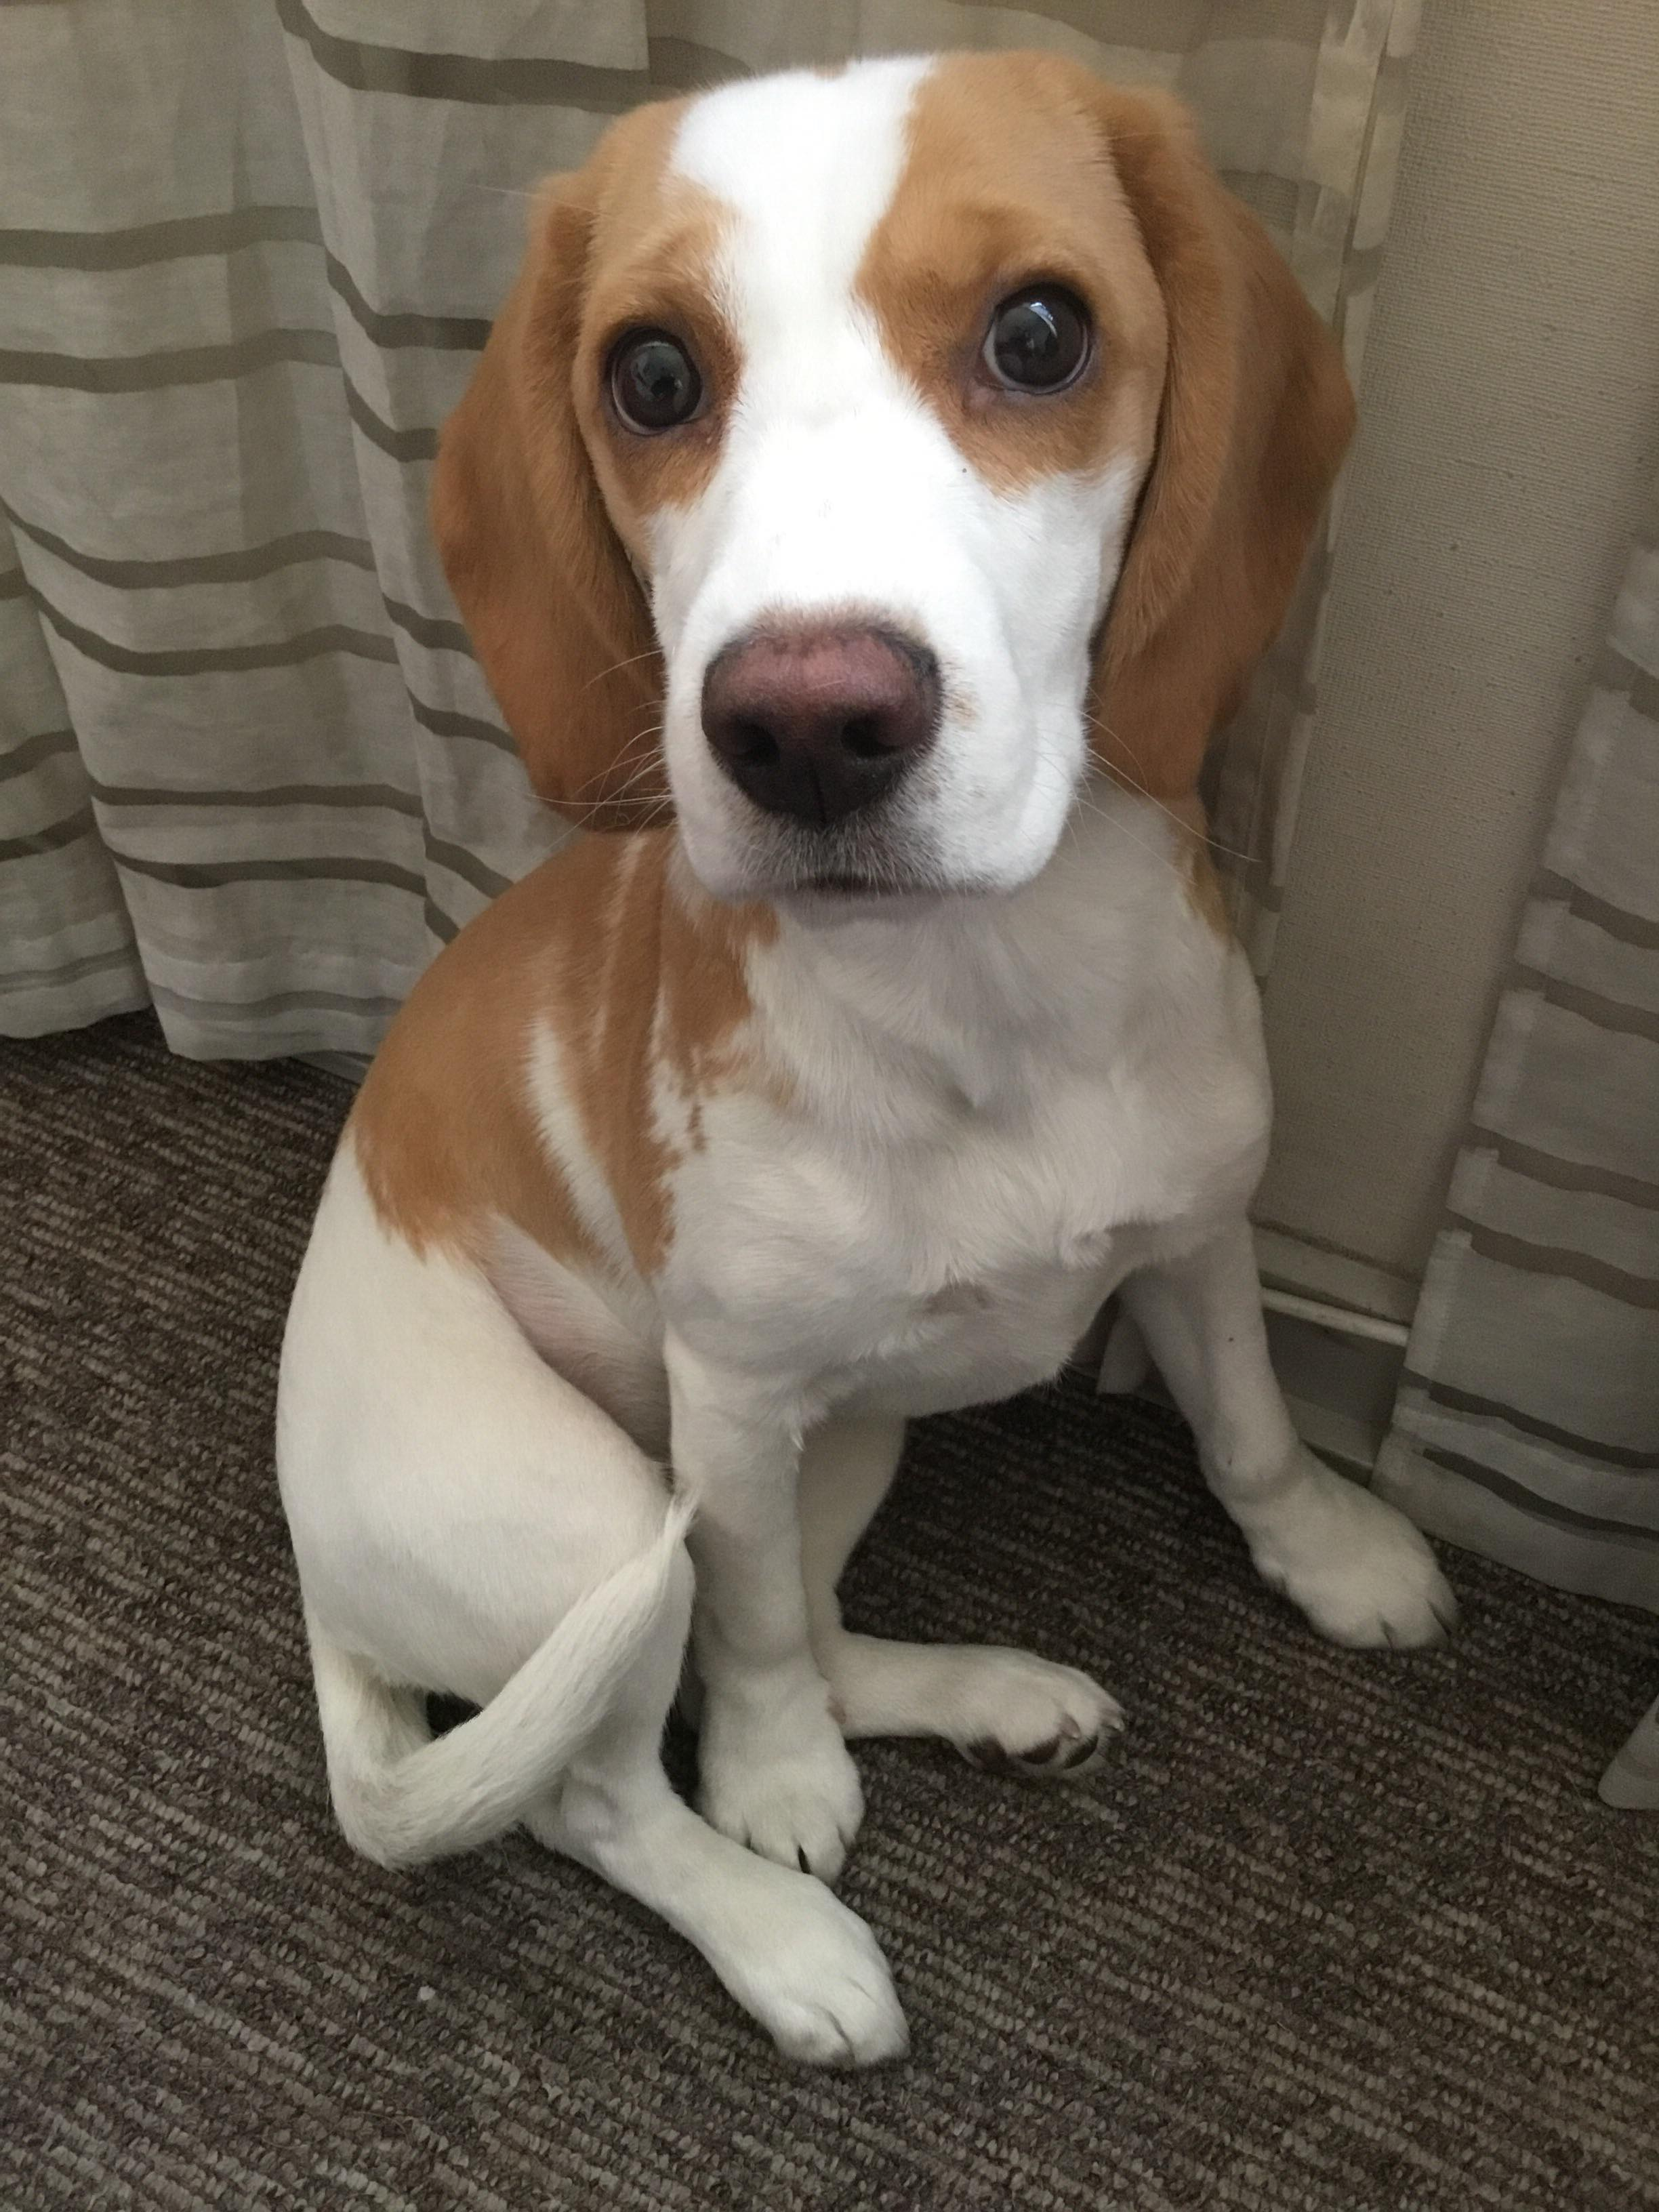

This is predicted to be a dog, and its breed is: 
Beagle


In [39]:
print(breed_algorithm("test5.jpg"))

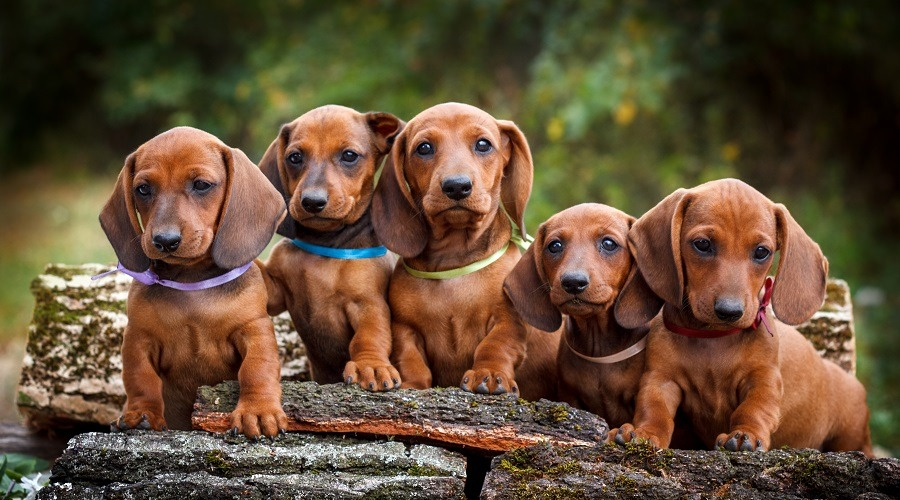

This is predicted to be a dog, and its breed is: 
Dachshund


In [47]:
print(breed_algorithm("test6.jpg"))